In [1]:

import matplotlib.pyplot as plt 
import os
import pandas as pd
import numpy as np 
import scipy.cluster.hierarchy as shc
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
import warnings
import re 
pd.set_option("display.max_rows", 10)
pd.set_option("display.max_columns", 25)
pd.set_option("display.precision", 5)
import seaborn as sb
sb.set_style('whitegrid')
warnings.filterwarnings('ignore', category=UserWarning, module='openpyxl')
current_dir=os.path.dirname(os.path.abspath("__file__"))
df0=pd.read_excel(os.path.join(current_dir, 'Агрегатный журнал сводный(Power Query).xlsx'), "Реестр")
#df_nab=pd.read_excel(os.path.join(current_dir, 'Сводный наблюдатель оперативной информации.xlsx'), "Реестр")

Загрузим датасет "Агрегатный журнал", отфильтруем по карьерной технике, по видам ремонта, добавим столбец с наработкой.

In [2]:
df1=df0

In [3]:
df1.columns

Index(['Год', 'Месяц', 'Подразделение', 'Тип машины', 'Марка', 'Модификация',
       'Инвентарный номер', 'Дата начала обслуживания',
       'Дата окончания обслуживания', 'Тип прибора учета работы',
       'Показания прибора учета', 'Наработка машины',
       'Состояние прибора учета', 'Тип обслуживания', 'ФИО ответственного',
       'Должность ответственного', 'ФИО ответсвенного за установку',
       'Дата установки запасной части', 'Группа деталей',
       'Наименование детали, материалов', 'Каталожный номер (Артикул)',
       'Единица измерения деталей', 'Количество деталей', 'Примечание',
       'Отметка главного механика о проверке'],
      dtype='object')

In [4]:
df1=df1.rename(columns={'Марка':'Марка или обозначение техники'})

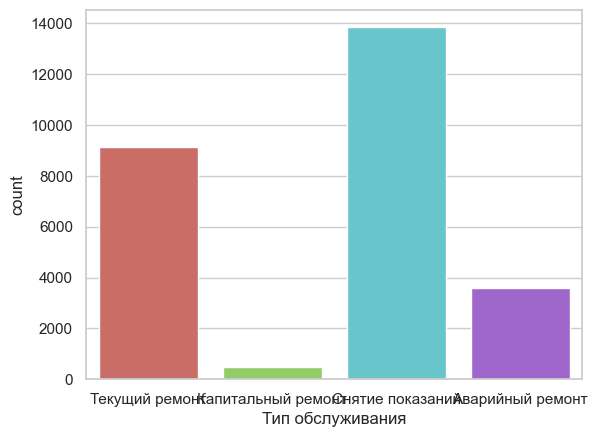

<Figure size 640x480 with 0 Axes>

In [5]:

agg_func_count = {'Наработка машины': ['count', 'nunique', 'mean']}
df1_1=df1.groupby(['Марка или обозначение техники','Инвентарный номер', 'Год'], as_index=False).agg(agg_func_count)

#Moto4=df1.groupby(['Тип обслуживания'], as_index=False).agg(agg_func_count)
df1=df1.loc[(df1['Тип обслуживания'] == "Снятие показаний")|(df1['Тип обслуживания'] == "Капитальный ремонт")|(df1['Тип обслуживания'] == "Текущий ремонт")|(df1['Тип обслуживания'] == "Аварийный ремонт")]
df1=df1.loc[(df1['Тип машины'] == "Бульдозер")|(df1['Тип машины'] == "Самосвал карьерный")|(df1['Тип машины'] == "Буровой станок")|(df1['Тип машины'] == "Погрузчик")|(df1['Тип машины'] == "Экскаватор")]
# сортировка
df1.loc[:,"Наработка"]=df1.loc[:,"Наработка машины"]
df1=df1.sort_values(by=["Инвентарный номер",'Дата начала обслуживания'])
df1.reset_index(drop=True, inplace=True) #сброс индекса
for i, row in df1.iterrows():
    if i>=1:     
        if  (df1.loc[i,"Инвентарный номер"]==df1.loc[i-1,"Инвентарный номер"]):
           # Moto4_pokaz.loc[i,"счетчик"]=Moto4_pokaz.loc[i-1,"счетчик"]+1
            df1.loc[i,"Наработка"]=df1.loc[i,"Наработка машины"]-df1.loc[i-1,"Наработка машины"]
        else: 
            df1.loc[i,"Наработка"]=0 
    
            
    else:
          #  Moto4_pokaz.loc[i,"счетчик"]=1
            df1.loc[i,"Наработка"]=0           
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

df1['Тип обслуживания'].value_counts()
sns.countplot(x='Тип обслуживания',data=df1, palette='hls')
plt.show()
plt.savefig('count_plot')



In [6]:
#извлечем из даты день
df1['День'] = df1['Дата начала обслуживания'].dt.day

введем значение ремонта. 1 - событие ремонта возникло, 0 - события не было

In [7]:

i=0
for i, row in df1.iterrows():
    
    if i>=1:    
        if  (df1.loc[i,"Инвентарный номер"]==df1.loc[i-1,"Инвентарный номер"])&(df1.loc[i,"Дата начала обслуживания"]!=df1.loc[i-1,"Дата начала обслуживания"]):
                  
         
            if  (df1.loc[i,"Тип обслуживания"]=='Снятие показаний'):
                # Moto4_pokaz.loc[i,"счетчик"]=Moto4_pokaz.loc[i-1,"счетчик"]+1
                df1.loc[i,"Ремонт"]=0
            if  ((df1.loc[i,"Тип обслуживания"]=='Текущий ремонт')or(df1.loc[i,"Тип обслуживания"]=='Капитальный ремонт')or(df1.loc[i,"Тип обслуживания"]=='Аварийный ремонт')):
                    # Moto4_pokaz.loc[i,"счетчик"]=Moto4_pokaz.loc[i-1,"счетчик"]+1
                df1.loc[i,"Ремонт"]=1
        
        else: 
                df1.loc[i,"Ремонт"]=2
    if i==0:  
          #  Moto4_pokaz.loc[i,"счетчик"]=1
         if  (df1.loc[i,"Тип обслуживания"]=='Снятие показаний'):
             # Moto4_pokaz.loc[i,"счетчик"]=Moto4_pokaz.loc[i-1,"счетчик"]+1
             df1.loc[i,"Ремонт"]=0
         if  ((df1.loc[i,"Тип обслуживания"]=='Текущий ремонт')or(df1.loc[i,"Тип обслуживания"]=='Капитальный ремонт')or(df1.loc[i,"Тип обслуживания"]=='Аварийный ремонт')):
                 # Moto4_pokaz.loc[i,"счетчик"]=Moto4_pokaz.loc[i-1,"счетчик"]+1
             df1.loc[i,"Ремонт"]=1
    
df2=df1
df1=df1.loc[(df1['Ремонт'] != 2)]   
#df1.to_excel('C:/Users/MSI/YandexDisk-shirobokov@pskgold.ru/Техника/21.12.2022/df1.xlsx', index = True)
########



In [8]:
df1['Ремонт'].unique()

array([1., 0.])

Экскаватор Case Инв 674 находиться продолжительное время в ремонте. Данные по нему занесены таким образом, что значиться Тип обслуживания "Снятие показаний", но по факту он находиться в нерабочем состоянии и проводиться ремонт. Такие данные испортят статистику, из анализа уберем.   
Также уберем столбец 'Тип обслуживания', поскольку он будет попадать в набор фитчей, которые влияют на предсказанное значение.

выберем данные для обучения

In [9]:

count_sub_train=df1.loc[(df1['Дата начала обслуживания'] <='2022-04-01')]

In [10]:
count_sub_train

,Год,Месяц,Подразделение,Тип машины,Марка или обозначение техники,Модификация,Инвентарный номер,Дата начала обслуживания,Дата окончания обслуживания,Тип прибора учета работы,Показания прибора учета,Наработка машины,...,ФИО ответсвенного за установку,Дата установки запасной части,Группа деталей,"Наименование детали, материалов",Каталожный номер (Артикул),Единица измерения деталей,Количество деталей,Примечание,Отметка главного механика о проверке,Наработка,День,Ремонт
0,2020.0,Февраль,Эрел,Бульдозер,Т-130,0,112.0,2020-02-27,2020-02-27,Мотосчётчик,NaN,NaN,...,Байгужин Р.Ф.,2020-02-27 00:00:00,Двигатель,Масло моторное,М-10ДМ,л.,20.0,NaN,Проверено,0.0,27,1.0
4,2020.0,Март,Эрел,Бульдозер,Т-130,0,112.0,2020-03-07,2020-03-07,Мотосчётчик,NaN,NaN,...,Байгужин Р.Ф.,2020-03-07 00:00:00,Двигатель,"Насос водяной 16-08-140СП,",16-08-140СП,шт.,1.0,NaN,Проверено,NaN,7,1.0
7,2020.0,Март,Эрел,Бульдозер,Т-130,0,112.0,2020-03-26,2020-03-26,Мотосчётчик,NaN,NaN,...,Байгужин Р.Ф.,2020-03-26 00:00:00,Двигатель,Масло моторное,М-10ДМ,л.,20.0,NaN,Проверено,NaN,26,1.0
8,2020.0,Март,Эрел,Бульдозер,Т-130,0,112.0,2020-03-30,2020-03-30,Мотосчётчик,NaN,NaN,...,Каранин А.Б.,2020-03-30 00:00:00,Гидросистема,"Рукав высокого давления Н.036.85.03.170-01,",Н.036.85.03.170-01,шт.,2.0,NaN,Проверено,NaN,30,1.0
10,2020.0,Апрель,Эрел,Бульдозер,Т-130,0,112.0,2020-04-03,2020-04-19,Мотосчётчик,NaN,NaN,...,Каранин А.Б.,2020-04-04 00:00:00,Двигатель,Трубка,2218,шт.,16.0,NaN,Проверено,NaN,3,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27019,2020.0,Октябрь,Талынья,Экскаватор,PC-400,7,1166.0,2020-10-05,2020-10-05,Мотосчётчик,16895.0,16895.0,...,Хаитов А.Б.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Проверено,0.0,5,0.0
27020,2020.0,Октябрь,Талынья,Экскаватор,PC-400,7,1166.0,2020-10-12,2020-10-12,Мотосчётчик,16895.0,16895.0,...,Хаитов А.Б.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Проверено,0.0,12,0.0
27021,2020.0,Октябрь,Талынья,Экскаватор,PC-400,7,1166.0,2020-10-19,2020-10-19,Мотосчётчик,16895.0,16895.0,...,Хаитов А.Б.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Проверено,0.0,19,0.0
27022,2020.0,Октябрь,Талынья,Экскаватор,PC-400,7,1166.0,2020-10-26,2020-10-26,Мотосчётчик,16895.0,16895.0,...,Хаитов А.Б.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Проверено,0.0,26,0.0


In [11]:
#count_sub_train=df1.loc[(df1['Год'] !=2023 )]
count_sub_train=count_sub_train[count_sub_train['Инвентарный номер'] != 674]
train_fith=count_sub_train.iloc[:,count_sub_train.columns != 'Тип обслуживания']
#train_labels=df1.iloc[0:7000,df1.columns == 'Ремонт']


In [12]:
train_fith.columns

Index(['Год', 'Месяц', 'Подразделение', 'Тип машины',
       'Марка или обозначение техники', 'Модификация', 'Инвентарный номер',
       'Дата начала обслуживания', 'Дата окончания обслуживания',
       'Тип прибора учета работы', 'Показания прибора учета',
       'Наработка машины', 'Состояние прибора учета', 'ФИО ответственного',
       'Должность ответственного', 'ФИО ответсвенного за установку',
       'Дата установки запасной части', 'Группа деталей',
       'Наименование детали, материалов', 'Каталожный номер (Артикул)',
       'Единица измерения деталей', 'Количество деталей', 'Примечание',
       'Отметка главного механика о проверке', 'Наработка', 'День', 'Ремонт'],
      dtype='object')

Чтобы мы смогли проанализировать по нескольким алгоритмам, предпочтительно будет, если мы данные переведем в цифровой вид. 

In [13]:
train_fith['ФИО ответственного'].unique()

array(['Шевченко С.С.', 'Подоляко В.Л.', 'Еремеев В.А.', 'Усачев А.И.',
       'Хаитов А.Б.', 'Андрийко В.А.', 'Тесленко В.В.', 'Савин Е.А.',
       'Хасанов Р.Н.', 'Гарнага В.С.', 'Русов С.Н.', 'Скориков А.Ю.',
       'Мороз Г.Г.', 'Никушев С.С.', 'Леонтьев С.В.'], dtype=object)

замениим все качественные фичи на количественные - для проведения анализа

In [14]:
train_fith['ФИО ответственного'] = train_fith['ФИО ответственного'].replace(['Шевченко С.С.', 'Подоляко В.Л.', 'Еремеев В.А.', 'Усачев А.И.',
       'Мороз Г.Г.', 'Хаитов А.Б.', 'Андрийко В.А.', 'Тесленко В.В.',
       'Савин Е.А.', 'Леонтьев С.В.', 'Хасанов Р.Н.', 'Гарнага В.С.',
       'Русов С.Н.', 'Скориков А.Ю.', 'Никушев С.С.'], [1,
2,
3,
4,
5,
6,
7,
8,
9,
10,
11,
12,
13,
14,
15
]) 

C:\Users\poisk-12\AppData\Local\Temp\ipykernel_4512\1569592155.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_fith['ФИО ответственного'] = train_fith['ФИО ответственного'].replace(['Шевченко С.С.', 'Подоляко В.Л.', 'Еремеев В.А.', 'Усачев А.И.',


C:\Users\poisk-12\AppData\Local\Temp\ipykernel_4512\4257971865.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_fith['Подразделение'] = train_fith['Подразделение'].replace(['Талынья', 'Большой Тарын', 'Тарын', 'Эрел', 'Айхал',
C:\Users\poisk-12\AppData\Local\Temp\ipykernel_4512\4257971865.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_fith['Тип машины'] = train_fith['Тип машины'].  replace([ 'Автозаправщик', 'Бульдозер', 'Легковой транспорт',


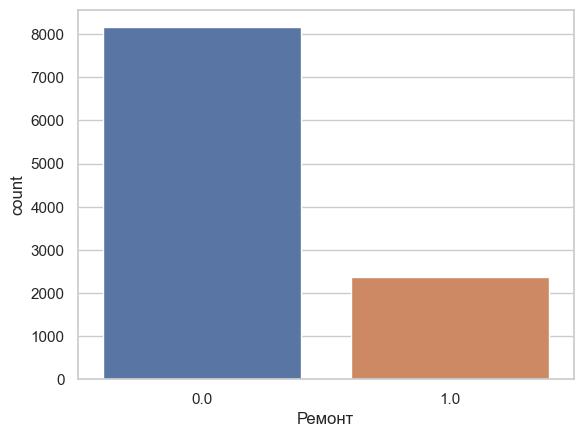

In [15]:
sb.countplot(x='Ремонт', data=train_fith)
#log_reg = LogisticRegression()
train_fith['Подразделение'].unique ()
train_fith['Подразделение'] = train_fith['Подразделение'].replace(['Талынья', 'Большой Тарын', 'Тарын', 'Эрел', 'Айхал',
       'Малый Тарын', 'АТП', 'Сайлык', 'Келлям', 'Калы-Кыс'], [1, 2,3,4,5,6,7,8,9,10]) 
train_fith['Тип машины'].unique ()
train_fith['Тип машины'] = train_fith['Тип машины'].  replace([ 'Автозаправщик', 'Бульдозер', 'Легковой транспорт',
'Грузовой транспорт', 'Промприбор', 'Водный транспорт',
'Самосвал карьерный', 'ДЭС', 'Автобус', 'Погрузчик вилочный',
'Буровой станок', 'Автокран', 'Прочее', 'Погрузчик',
'Зарадная установка', 'Экскаватор', 'Насосная станция',
'Водовозка'], [1, 2, 3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18])     



In [16]:
train_fith['Группа деталей'].unique ()

array(['Двигатель', 'Гидросистема', 'Трансмиссия', 'Рабочее оборудование',
       'Ходовая часть', nan, 'Рулевое управление', 'Тормозная система',
       'Компрессор', 'Кузов', 'Поворотная платформа', 'Рама',
       'Двигатель ', 'Буровое оборудование', 'Электрооборудование ',
       'Навесное оборудование', 'Ходовая', 'Электрооборудование',
       'кабина', 'Навесное ', 'Инструмент', 'бензопила', 'Ходовая ',
       'Гиросистема', 'Ходовая часть ', 'Насосоное оборудование',
       'Кабина', 'Электооборудование', 'Кабина ', ' Ходовая', 'Навесное'],
      dtype=object)

In [17]:
train_fith['Группа деталей'] = train_fith['Группа деталей'].  replace([ 'Двигатель', 'Гидросистема', 'Трансмиссия', 'Рабочее оборудование',
       'Ходовая часть', 'Рулевое управление', 'Тормозная система',
       'Компрессор', 'Кузов', 'Поворотная платформа', 'Рама',
       'Навесное оборудование', 'Двигатель ', 'Буровое оборудование',
       'Электрооборудование ', 'Ходовая', 'Электрооборудование', 'кабина',
       'Навесное ', 'Инструмент', 'бензопила', 'Ходовая ', 'Гиросистема',
       'Ходовая часть ', 'Насосоное оборудование', 'Гидравлика', 'Кабина',
       'Электооборудование', 'Кабина ', ' Ходовая', 'Навесное',
       'Пневмосистема', 'Буровое оборудлвание'], [1, 2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33])

C:\Users\poisk-12\AppData\Local\Temp\ipykernel_4512\129851070.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_fith['Группа деталей'] = train_fith['Группа деталей'].  replace([ 'Двигатель', 'Гидросистема', 'Трансмиссия', 'Рабочее оборудование',


In [18]:
train_fith.dtypes

Год                                     float64
Месяц                                    object
Подразделение                            object
Тип машины                                int64
Марка или обозначение техники            object
                                         ...   
Примечание                               object
Отметка главного механика о проверке     object
Наработка                               float64
День                                      int64
Ремонт                                  float64
Length: 27, dtype: object

In [19]:
train_fith['Дата начала обслуживания'] = pd.to_datetime(train_fith['Дата начала обслуживания'])

C:\Users\poisk-12\AppData\Local\Temp\ipykernel_4512\1009850804.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_fith['Дата начала обслуживания'] = pd.to_datetime(train_fith['Дата начала обслуживания'])


In [20]:
train_fith.columns

Index(['Год', 'Месяц', 'Подразделение', 'Тип машины',
       'Марка или обозначение техники', 'Модификация', 'Инвентарный номер',
       'Дата начала обслуживания', 'Дата окончания обслуживания',
       'Тип прибора учета работы', 'Показания прибора учета',
       'Наработка машины', 'Состояние прибора учета', 'ФИО ответственного',
       'Должность ответственного', 'ФИО ответсвенного за установку',
       'Дата установки запасной части', 'Группа деталей',
       'Наименование детали, материалов', 'Каталожный номер (Артикул)',
       'Единица измерения деталей', 'Количество деталей', 'Примечание',
       'Отметка главного механика о проверке', 'Наработка', 'День', 'Ремонт'],
      dtype='object')

In [21]:
train_fith = train_fith.drop(columns=['Группа деталей','Марка или обозначение техники','Состояние прибора учета','Дата начала обслуживания','Дата окончания обслуживания','Модификация','Инвентарный номер','Тип прибора учета работы','Подразделение',
       'Должность ответственного', 'ФИО ответсвенного за установку',
       'Дата установки запасной части', 'Группа деталей',
       'Наименование детали, материалов', 'Каталожный номер (Артикул)',
       'Единица измерения деталей', 'Количество деталей', 'Примечание',
       'Отметка главного механика о проверке']) 
train_fith['Месяц'] = train_fith['Месяц'].  replace([ 'Январь', 'Февраль','Март', 'Апрель', 'Май', 'Июнь', 'Июль', 'Август', 'Сентябрь','Октябрь','Ноябрь', 'Декабрь'], [1, 2,3,4,5,6,7,8,9,10,11,12])  
train_fith= train_fith.fillna(0)

In [22]:
train_fith.head()

,Год,Месяц,Тип машины,Показания прибора учета,Наработка машины,ФИО ответственного,Наработка,День,Ремонт
0,2020.0,2,2,0.0,0.0,1,0.0,27,1.0
4,2020.0,3,2,0.0,0.0,1,0.0,7,1.0
7,2020.0,3,2,0.0,0.0,1,0.0,26,1.0
8,2020.0,3,2,0.0,0.0,1,0.0,30,1.0
10,2020.0,4,2,0.0,0.0,1,0.0,3,1.0


Чтобы обучить модель, разделим данные на тренировочные и тестовые. В тренировочные выделим 70% данных, тестовые 30%.
Тренировочные - это данные для обучения моделей машинного обучения.
Тестовые - это данные, которые модели не видят

In [23]:
df_train=train_fith.sample(frac=0.7)

In [24]:
#df_test=train_fith.drop(df_train.index)
df_test=df1.loc[(df1['Дата начала обслуживания'] > '2022-04-01')]

In [25]:
df_train

,Год,Месяц,Тип машины,Показания прибора учета,Наработка машины,ФИО ответственного,Наработка,День,Ремонт
22440,2021.0,10,2,22424.0,22424.0,6,0.0,25,0.0
11701,2021.0,9,2,21492.0,21492.0,6,104.0,27,0.0
14244,2021.0,6,2,4114.0,4114.0,6,7.0,7,0.0
17345,2021.0,11,2,2745.0,2745.0,1,0.0,8,0.0
2305,2021.0,7,7,1019.0,71019.0,8,62.0,19,0.0
...,...,...,...,...,...,...,...,...,...
7446,2021.0,9,2,16518.0,16518.0,6,79.0,11,1.0
10970,2020.0,10,2,21007.0,21007.0,6,132.0,19,0.0
2108,2021.0,8,7,15320.0,15320.0,8,0.0,16,0.0
17347,2022.0,2,2,2745.0,2745.0,13,0.0,21,0.0


Инициализация моделей машинного обучения.
Модели будут предсказывать Целевой стобец - "Ремонт", на основе других фичей (столбцов).  

In [26]:
#!pip install --pre pycaret

In [27]:
data=df_train
from pycaret.classification import *
#from pycaret.regression import *
data.describe() #сттитичка 
clf = setup(data, target = "Ремонт",session_id = 1, normalize=1)


,Description,Value
0,Session id,1
1,Target,Ремонт
2,Target type,Binary
3,Original data shape,"(7372, 9)"
4,Transformed data shape,"(7372, 9)"
5,Transformed train set shape,"(5160, 9)"
6,Transformed test set shape,"(2212, 9)"
7,Numeric features,8
8,Preprocess,True
9,Imputation type,simple


какие модели есть в библиотеке pycaret

In [28]:
models()

,Name,Reference,Turbo
ID,,,
lr,Logistic Regression,sklearn.linear_model._logistic.LogisticRegression,True
knn,K Neighbors Classifier,sklearn.neighbors._classification.KNeighborsCl...,True
nb,Naive Bayes,sklearn.naive_bayes.GaussianNB,True
dt,Decision Tree Classifier,sklearn.tree._classes.DecisionTreeClassifier,True
svm,SVM - Linear Kernel,sklearn.linear_model._stochastic_gradient.SGDC...,True
rbfsvm,SVM - Radial Kernel,sklearn.svm._classes.SVC,False
gpc,Gaussian Process Classifier,sklearn.gaussian_process._gpc.GaussianProcessC...,False
mlp,MLP Classifier,sklearn.neural_network._multilayer_perceptron....,False
ridge,Ridge Classifier,sklearn.linear_model._ridge.RidgeClassifier,True


Создадим и обучим модели.
- Accuracy - вероятность
- AUC Значение AUC может находиться в диапазоне от 0 до 1, где значение 0 означает, что модель классифицирует все объекты неправильно, а значение 1 означает, что модель классифицирует все объекты правильно. Чем выше значение AUC, тем лучше модель классифицирует объекты.
- Recall- чувствительность. это метрика качества в задачах классификации, которая описывает способность модели правильно классифицировать объекты положительного класса.Чувствительность показывает, насколько хорошо модель может идентифицировать объекты положительного класса
- Точность (precision) - это метрика оценки производительности классификатора, которая определяется как отношение числа правильно классифицированных положительных примеров (True Positives) к общему числу примеров. Например, если мы разрабатываем систему, которая определяет, является ли электронное письмо спамом, то ложноположительные решения могут привести к тому, что настоящие письма будут помечены как спам и не будут доставлены адресату, что может быть очень дорогостоящей ошибкой
- F-мера (F1-мера) - это гармоническое среднее между точностью (precision) и полнотой (recall) классификатора.

In [29]:
%%time
best_model = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.8992,0.9325,0.6098,0.9237,0.7340,0.6751,0.6976,1.9910
gbc,Gradient Boosting Classifier,0.8566,0.8787,0.4054,0.9242,0.5631,0.4927,0.5529,2.6460
rf,Random Forest Classifier,0.8504,0.8761,0.4750,0.7881,0.5919,0.5071,0.5320,2.0340
et,Extra Trees Classifier,0.8469,0.8740,0.4911,0.7548,0.5940,0.5050,0.5232,1.9320
ada,Ada Boost Classifier,0.8411,0.8467,0.4054,0.8033,0.5382,0.4545,0.4937,2.0440
knn,K Neighbors Classifier,0.8050,0.7196,0.3707,0.6259,0.4650,0.3552,0.3738,2.0050
dt,Decision Tree Classifier,0.8039,0.7245,0.5785,0.5710,0.5743,0.4469,0.4473,1.6440
qda,Quadratic Discriminant Analysis,0.7828,0.6730,0.0662,0.7868,0.1206,0.0896,0.1829,1.7420
lr,Logistic Regression,0.7758,0.6298,0.0195,0.8667,0.0380,0.0293,0.1099,3.3440
lda,Linear Discriminant Analysis,0.7754,0.6279,0.0178,0.8667,0.0348,0.0268,0.1055,1.7460


Processing:   0%|          | 0/61 [00:00<?, ?it/s]

CPU times: total: 4min 27s
Wall time: 5min 9s


Наиболее лучший результат показал алгоритм Light Gradient Boosting Machine - эффективный алгоритм градиентного бустинга, разработанный Microsoft 

как обучалась модель. обучается она на основе предыдущего этапа

In [30]:
lightgbm = create_model('lightgbm', cross_val=True)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8895,0.9389,0.5556,0.9286,0.6952,0.6329,0.6640
1,0.8973,0.9285,0.5847,0.9452,0.7225,0.6637,0.6926
2,0.8992,0.9325,0.6271,0.9024,0.7400,0.6800,0.6973
3,0.9012,0.9365,0.6102,0.9351,0.7385,0.6808,0.7044
4,0.9031,0.9139,0.6525,0.8953,0.7549,0.6964,0.7099
5,0.9031,0.9276,0.6356,0.9146,0.7500,0.6923,0.7099
6,0.9070,0.9423,0.6356,0.9375,0.7576,0.7026,0.7229
7,0.9031,0.9358,0.6186,0.9359,0.7449,0.6881,0.7106
8,0.8992,0.9386,0.5932,0.9459,0.7292,0.6712,0.6988


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

Тюнинг. После того, как отобрали лучшую модель, мы можем отобрать автоматически лучшие гиперпараметры. 

In [31]:
tuned_lightgbm=lightgbm

In [32]:
#tuned_lightgbm=tune_model(lightgbm,optimize='Accuracy')

In [33]:
lightgbm = create_model('lightgbm')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8895,0.9389,0.5556,0.9286,0.6952,0.6329,0.6640
1,0.8973,0.9285,0.5847,0.9452,0.7225,0.6637,0.6926
2,0.8992,0.9325,0.6271,0.9024,0.7400,0.6800,0.6973
3,0.9012,0.9365,0.6102,0.9351,0.7385,0.6808,0.7044
4,0.9031,0.9139,0.6525,0.8953,0.7549,0.6964,0.7099
5,0.9031,0.9276,0.6356,0.9146,0.7500,0.6923,0.7099
6,0.9070,0.9423,0.6356,0.9375,0.7576,0.7026,0.7229
7,0.9031,0.9358,0.6186,0.9359,0.7449,0.6881,0.7106
8,0.8992,0.9386,0.5932,0.9459,0.7292,0.6712,0.6988


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

Калибровка модели.
Мы хотели бы видеть с какой вероятностью модель уверена в своем значение, для этого проведем калибровку модели.

In [34]:

lightgbm_calibration=calibrate_model(tuned_lightgbm)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8876,0.9396,0.6239,0.8391,0.7157,0.6475,0.6586
1,0.8818,0.9307,0.6017,0.8353,0.6995,0.6283,0.6414
2,0.9050,0.9340,0.6949,0.8632,0.7700,0.7110,0.7176
3,0.8992,0.9330,0.6271,0.9024,0.7400,0.6800,0.6973
4,0.8915,0.9077,0.6525,0.8370,0.7333,0.6665,0.6746
5,0.8915,0.9163,0.6271,0.8605,0.7255,0.6599,0.6727
6,0.8992,0.9325,0.6441,0.8837,0.7451,0.6842,0.6975
7,0.9089,0.9371,0.6525,0.9277,0.7662,0.7117,0.7287
8,0.9147,0.9374,0.6949,0.9111,0.7885,0.7363,0.7469


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

ValueError: keyword grid_b is not recognized; valid keywords are ['size', 'width', 'color', 'tickdir', 'pad', 'labelsize', 'labelcolor', 'zorder', 'gridOn', 'tick1On', 'tick2On', 'label1On', 'label2On', 'length', 'direction', 'left', 'bottom', 'right', 'top', 'labelleft', 'labelbottom', 'labelright', 'labeltop', 'labelrotation', 'grid_agg_filter', 'grid_alpha', 'grid_animated', 'grid_antialiased', 'grid_clip_box', 'grid_clip_on', 'grid_clip_path', 'grid_color', 'grid_dash_capstyle', 'grid_dash_joinstyle', 'grid_dashes', 'grid_data', 'grid_drawstyle', 'grid_figure', 'grid_fillstyle', 'grid_gapcolor', 'grid_gid', 'grid_in_layout', 'grid_label', 'grid_linestyle', 'grid_linewidth', 'grid_marker', 'grid_markeredgecolor', 'grid_markeredgewidth', 'grid_markerfacecolor', 'grid_markerfacecoloralt', 'grid_markersize', 'grid_markevery', 'grid_mouseover', 'grid_path_effects', 'grid_picker', 'grid_pickradius', 'grid_rasterized', 'grid_sketch_params', 'grid_snap', 'grid_solid_capstyle', 'grid_solid_joinstyle', 'grid_transform', 'grid_url', 'grid_visible', 'grid_xdata', 'grid_ydata', 'grid_zorder', 'grid_aa', 'grid_c', 'grid_ds', 'grid_ls', 'grid_lw', 'grid_mec', 'grid_mew', 'grid_mfc', 'grid_mfcalt', 'grid_ms']

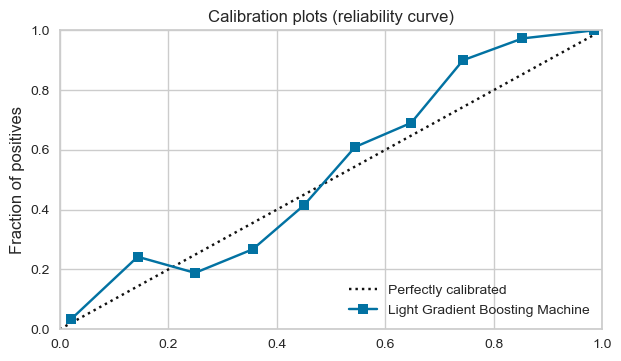

In [35]:
plot_model(lightgbm_calibration, plot = 'calibration')

Представлена матрица ошибок модели. 
горизонталь - указывает на прогнозные значения, вертикаль - фактическое значение.


Интерпретация модели


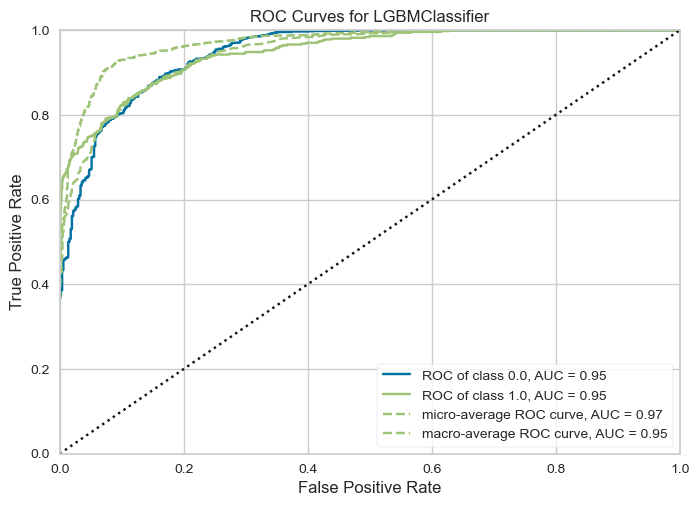

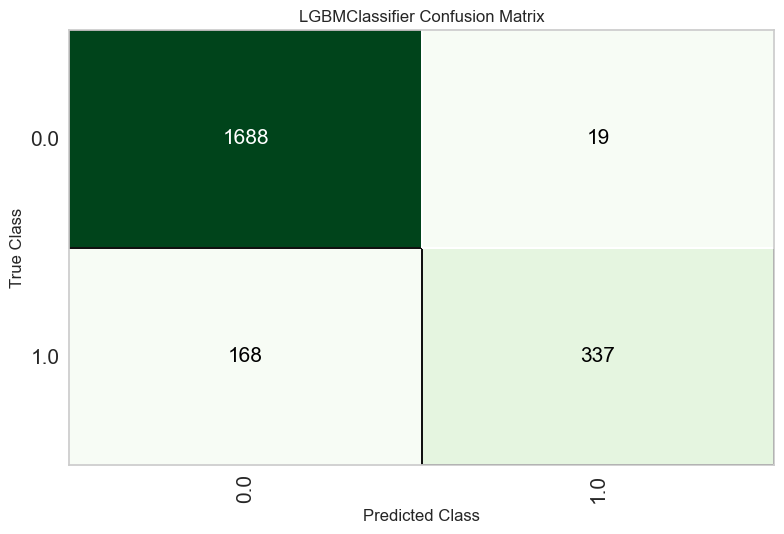

In [36]:
plot_model(tuned_lightgbm)
plot_model(tuned_lightgbm, plot = 'confusion_matrix')

Важность показателей.

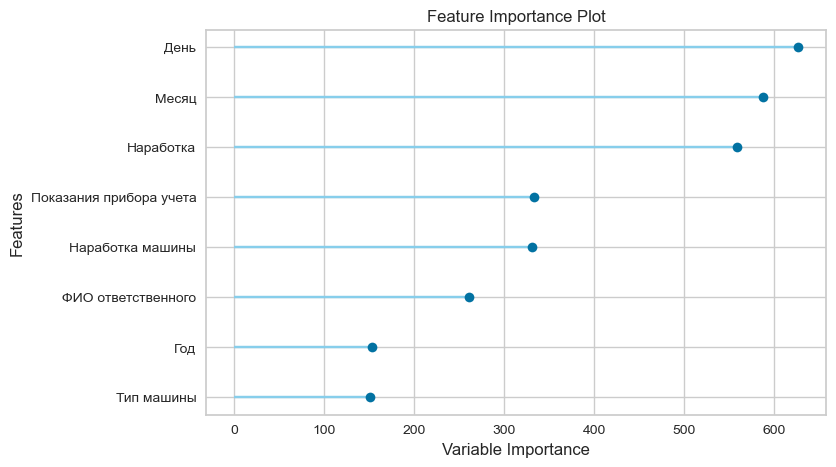

In [37]:
plot_model(tuned_lightgbm, plot = 'feature')

Если мы хотим проверить качество модели на отложенной выборке, вызовем следующий метод. Точность составляет 

In [38]:
pred_holdouts = predict_model(tuned_lightgbm)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.9155,0.9470,0.6673,0.9466,0.7828,0.7323,0.7495


In [39]:
pred_holdouts

,Год,Месяц,Тип машины,Показания прибора учета,Наработка машины,ФИО ответственного,Наработка,День,Ремонт,prediction_label,prediction_score
1889,2020.0,9,7,29314.0,29314.0,3,59.0,7,0.0,0,0.7945
7598,2020.0,6,7,7937.0,7937.0,2,0.0,15,0.0,0,0.9590
81,2020.0,7,7,11000.0,11000.0,2,95.0,6,0.0,0,0.9490
12590,2022.0,2,2,11530.0,11530.0,12,0.0,21,0.0,0,0.9989
21948,2021.0,5,2,14898.0,20459.0,7,0.0,21,1.0,1,0.9004
...,...,...,...,...,...,...,...,...,...,...,...
15686,2020.0,5,2,14469.0,14469.0,6,0.0,18,0.0,0,0.8277
15506,2020.0,5,2,16877.0,16877.0,6,4.0,5,1.0,1,0.9339
9285,2020.0,8,7,8214.0,8214.0,11,87.0,3,0.0,0,0.9424
26033,2022.0,2,7,4420.0,4420.0,13,0.0,21,0.0,0,0.9989


После того, как мы прошли весь пайплайн, мы хотим получть модель, которая будет использоваться в продакшн. 

In [40]:
final_lightgbm=finalize_model(tuned_lightgbm)

Посмотрим на гиперпараметры модели

In [41]:
#print(final_lightgbm)

In [42]:
predict_model(final_lightgbm);

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.9259,0.9245,0.6812,0.9914,0.8075,0.7635,0.7842


Изначально мы делили данные на тренировочные и тестовые. Тестовые модель никогда не видела. Посмотрим, как сработает модель на тестовых данных.
Добавяться столбцы 
prediction_label - предсказанная метка
prediction_score - вероятность, мера уверенности в предсказании. 

In [43]:
df_test.dropna(subset=['Ремонт'], inplace=True)

In [44]:
df_test.head()

,Год,Месяц,Подразделение,Тип машины,Марка или обозначение техники,Модификация,Инвентарный номер,Дата начала обслуживания,Дата окончания обслуживания,Тип прибора учета работы,...,Группа деталей,"Наименование детали, материалов",Каталожный номер (Артикул),Единица измерения деталей,Количество деталей,Примечание,Отметка главного механика о проверке,Наработка,День,Ремонт
460,2022.0,Апрель,Талынья,Экскаватор,ЭКГ,5А,169.0,2022-04-27,2022-04-27,Мотосчётчик,...,Навесное оборудование,Зуб ковша,1080.02.10-1СБ,шт.,5.000,Требование № 71,Проверено,NaN,27,1.0
462,2022.0,Май,Талынья,Экскаватор,ЭКГ,5А,169.0,2022-05-03,2022-05-03,Мотосчётчик,...,Рабочее оборудование,Консистентная смазка,Смазка графитная,кг.,23.000,Требование № 84,Проверено,NaN,3,1.0
468,2022.0,Май,Талынья,Экскаватор,ЭКГ,5А,169.0,2022-05-16,2022-05-16,Мотосчётчик,...,Рабочее оборудование,Канат Ø39,NaN,км.,0.026,Требование № 133,Проверено,NaN,16,1.0
469,2022.0,Май,Талынья,Экскаватор,ЭКГ,5А,169.0,2022-05-20,2022-05-20,Мотосчётчик,...,Навесное оборудование,Зуб ковша,1080.02.10-1СБ,шт.,5.000,Требование № 121,Проверено,NaN,20,1.0
470,2022.0,Май,Талынья,Экскаватор,ЭКГ,5А,169.0,2022-05-29,2022-05-29,Мотосчётчик,...,Рабочее оборудование,Канат Ø39,NaN,км.,0.060,Требование № 137,Проверено,NaN,29,1.0


In [45]:
df_test['Тип машины'].unique ()

array(['Экскаватор', 'Буровой станок', 'Самосвал карьерный', 'Бульдозер',
       'Погрузчик'], dtype=object)

In [46]:

df_test['Тип машины'] = df_test['Тип машины'].  replace([ 'Автозаправщик', 'Бульдозер', 'Легковой транспорт',
'Грузовой транспорт', 'Промприбор', 'Водный транспорт',
'Самосвал карьерный', 'ДЭС', 'Автобус', 'Погрузчик вилочный',
'Буровой станок', 'Автокран', 'Прочее', 'Погрузчик',
'Зарадная установка', 'Экскаватор', 'Насосная станция',
'Водовозка'], [1, 2, 3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18]) 



In [47]:
df_test['Тип обслуживания'].unique()

array(['Текущий ремонт', 'Аварийный ремонт', 'Снятие показаний',
       'Капитальный ремонт'], dtype=object)

In [48]:
df_test['Тип обслуживания'] = df_test['Тип обслуживания'].  replace([ 'Текущий ремонт', 'Аварийный ремонт', 'Капитальный ремонт','Снятие показаний'], [1, 2, 3,4])     

In [49]:
'''df_test = df_test.drop(columns=['Группа деталей','Марка или обозначение техники','Состояние прибора учета','Дата начала обслуживания','Дата окончания обслуживания','Модификация','Инвентарный номер','Тип прибора учета работы','Подразделение',
       'Должность ответственного', 'ФИО ответсвенного за установку',
       'Дата установки запасной части', 'Группа деталей',
       'Наименование детали, материалов', 'Каталожный номер (Артикул)',
       'Единица измерения деталей', 'Количество деталей', 'Примечание',
       'Отметка главного механика о проверке']) 
'''
df_test['Месяц'] = df_test['Месяц'].  replace([ 'Январь', 'Февраль','Март', 'Апрель', 'Май', 'Июнь', 'Июль', 'Август', 'Сентябрь','Октябрь','Ноябрь', 'Декабрь'], [1, 2,3,4,5,6,7,8,9,10,11,12])  
df_test= df_test.fillna(0)

In [50]:
df_test

,Год,Месяц,Подразделение,Тип машины,Марка или обозначение техники,Модификация,Инвентарный номер,Дата начала обслуживания,Дата окончания обслуживания,Тип прибора учета работы,...,Группа деталей,"Наименование детали, материалов",Каталожный номер (Артикул),Единица измерения деталей,Количество деталей,Примечание,Отметка главного механика о проверке,Наработка,День,Ремонт
460,2022.0,4,Талынья,16,ЭКГ,5А,169.0,2022-04-27,2022-04-27 00:00:00,Мотосчётчик,...,Навесное оборудование,Зуб ковша,1080.02.10-1СБ,шт.,5.000,Требование № 71,Проверено,0.0,27,1.0
462,2022.0,5,Талынья,16,ЭКГ,5А,169.0,2022-05-03,2022-05-03 00:00:00,Мотосчётчик,...,Рабочее оборудование,Консистентная смазка,Смазка графитная,кг.,23.000,Требование № 84,Проверено,0.0,3,1.0
468,2022.0,5,Талынья,16,ЭКГ,5А,169.0,2022-05-16,2022-05-16 00:00:00,Мотосчётчик,...,Рабочее оборудование,Канат Ø39,0,км.,0.026,Требование № 133,Проверено,0.0,16,1.0
469,2022.0,5,Талынья,16,ЭКГ,5А,169.0,2022-05-20,2022-05-20 00:00:00,Мотосчётчик,...,Навесное оборудование,Зуб ковша,1080.02.10-1СБ,шт.,5.000,Требование № 121,Проверено,0.0,20,1.0
470,2022.0,5,Талынья,16,ЭКГ,5А,169.0,2022-05-29,2022-05-29 00:00:00,Мотосчётчик,...,Рабочее оборудование,Канат Ø39,0,км.,0.060,Требование № 137,Проверено,0.0,29,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26966,2023.0,4,Талынья,16,PC-750,7,1162.0,2023-04-03,2023-04-03 00:00:00,Мотосчётчик,...,0,0,0,0,0.000,0,Проверено,0.0,3,0.0
26967,2023.0,4,Талынья,16,PC-750,7,1162.0,2023-04-10,2023-04-10 00:00:00,Мотосчётчик,...,0,0,0,0,0.000,0,Проверено,0.0,10,0.0
26968,2023.0,4,Талынья,16,PC-750,7,1162.0,2023-04-17,2023-04-17 00:00:00,Мотосчётчик,...,0,0,0,0,0.000,0,Проверено,0.0,17,0.0
26969,2023.0,5,Талынья,16,PC-750,7,1162.0,2023-05-01,2023-05-01 00:00:00,Мотосчётчик,...,0,0,0,0,0.000,0,Проверено,0.0,1,0.0


In [51]:
df_test['ФИО ответственного'] = df_test['ФИО ответственного'].replace(['Шевченко С.С.', 'Подоляко В.Л.', 'Еремеев В.А.', 'Усачев А.И.',
       'Мороз Г.Г.', 'Хаитов А.Б.', 'Андрийко В.А.', 'Тесленко В.В.',
       'Савин Е.А.', 'Леонтьев С.В.', 'Хасанов Р.Н.', 'Гарнага В.С.',
       'Русов С.Н.', 'Скориков А.Ю.', 'Никушев С.С.','Малюк В.В.','Довгаль С.В.'], [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17]) 

In [52]:
unseen_predictions=predict_model(final_lightgbm, data=df_test)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.6465,0.6358,0.4833,0.2209,0.3032,0.1084,0.1234


In [53]:

unseen_predictions


,Год,Месяц,Подразделение,Тип машины,Марка или обозначение техники,Модификация,Инвентарный номер,Дата начала обслуживания,Дата окончания обслуживания,Тип прибора учета работы,...,Каталожный номер (Артикул),Единица измерения деталей,Количество деталей,Примечание,Отметка главного механика о проверке,Наработка,День,Ремонт,prediction_label,prediction_score
460,2022.0,4,Талынья,16,ЭКГ,5А,169.0,2022-04-27,2022-04-27 00:00:00,Мотосчётчик,...,1080.02.10-1СБ,шт.,5.000,Требование № 71,Проверено,0.0,27,1.0,1,0.9956
462,2022.0,5,Талынья,16,ЭКГ,5А,169.0,2022-05-03,2022-05-03 00:00:00,Мотосчётчик,...,Смазка графитная,кг.,23.000,Требование № 84,Проверено,0.0,3,1.0,1,0.9922
468,2022.0,5,Талынья,16,ЭКГ,5А,169.0,2022-05-16,2022-05-16 00:00:00,Мотосчётчик,...,0,км.,0.026,Требование № 133,Проверено,0.0,16,1.0,1,0.9984
469,2022.0,5,Талынья,16,ЭКГ,5А,169.0,2022-05-20,2022-05-20 00:00:00,Мотосчётчик,...,1080.02.10-1СБ,шт.,5.000,Требование № 121,Проверено,0.0,20,1.0,1,0.9968
470,2022.0,5,Талынья,16,ЭКГ,5А,169.0,2022-05-29,2022-05-29 00:00:00,Мотосчётчик,...,0,км.,0.060,Требование № 137,Проверено,0.0,29,1.0,1,0.9985
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26966,2023.0,4,Талынья,16,PC-750,7,1162.0,2023-04-03,2023-04-03 00:00:00,Мотосчётчик,...,0,0,0.000,0,Проверено,0.0,3,0.0,0,0.8908
26967,2023.0,4,Талынья,16,PC-750,7,1162.0,2023-04-10,2023-04-10 00:00:00,Мотосчётчик,...,0,0,0.000,0,Проверено,0.0,10,0.0,0,0.7139
26968,2023.0,4,Талынья,16,PC-750,7,1162.0,2023-04-17,2023-04-17 00:00:00,Мотосчётчик,...,0,0,0.000,0,Проверено,0.0,17,0.0,0,0.8129
26969,2023.0,5,Талынья,16,PC-750,7,1162.0,2023-05-01,2023-05-01 00:00:00,Мотосчётчик,...,0,0,0.000,0,Проверено,0.0,1,0.0,1,0.7114


Измерим точность модели, параметр Accuracy

In [54]:
unseen_predictions

,Год,Месяц,Подразделение,Тип машины,Марка или обозначение техники,Модификация,Инвентарный номер,Дата начала обслуживания,Дата окончания обслуживания,Тип прибора учета работы,...,Каталожный номер (Артикул),Единица измерения деталей,Количество деталей,Примечание,Отметка главного механика о проверке,Наработка,День,Ремонт,prediction_label,prediction_score
460,2022.0,4,Талынья,16,ЭКГ,5А,169.0,2022-04-27,2022-04-27 00:00:00,Мотосчётчик,...,1080.02.10-1СБ,шт.,5.000,Требование № 71,Проверено,0.0,27,1.0,1,0.9956
462,2022.0,5,Талынья,16,ЭКГ,5А,169.0,2022-05-03,2022-05-03 00:00:00,Мотосчётчик,...,Смазка графитная,кг.,23.000,Требование № 84,Проверено,0.0,3,1.0,1,0.9922
468,2022.0,5,Талынья,16,ЭКГ,5А,169.0,2022-05-16,2022-05-16 00:00:00,Мотосчётчик,...,0,км.,0.026,Требование № 133,Проверено,0.0,16,1.0,1,0.9984
469,2022.0,5,Талынья,16,ЭКГ,5А,169.0,2022-05-20,2022-05-20 00:00:00,Мотосчётчик,...,1080.02.10-1СБ,шт.,5.000,Требование № 121,Проверено,0.0,20,1.0,1,0.9968
470,2022.0,5,Талынья,16,ЭКГ,5А,169.0,2022-05-29,2022-05-29 00:00:00,Мотосчётчик,...,0,км.,0.060,Требование № 137,Проверено,0.0,29,1.0,1,0.9985
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26966,2023.0,4,Талынья,16,PC-750,7,1162.0,2023-04-03,2023-04-03 00:00:00,Мотосчётчик,...,0,0,0.000,0,Проверено,0.0,3,0.0,0,0.8908
26967,2023.0,4,Талынья,16,PC-750,7,1162.0,2023-04-10,2023-04-10 00:00:00,Мотосчётчик,...,0,0,0.000,0,Проверено,0.0,10,0.0,0,0.7139
26968,2023.0,4,Талынья,16,PC-750,7,1162.0,2023-04-17,2023-04-17 00:00:00,Мотосчётчик,...,0,0,0.000,0,Проверено,0.0,17,0.0,0,0.8129
26969,2023.0,5,Талынья,16,PC-750,7,1162.0,2023-05-01,2023-05-01 00:00:00,Мотосчётчик,...,0,0,0.000,0,Проверено,0.0,1,0.0,1,0.7114


In [55]:
unseen_predictions['Тип машины'].unique ()
unseen_predictions['Тип машины'] = unseen_predictions['Тип машины'].  replace([1, 2, 3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18],[ 'Автозаправщик', 'Бульдозер', 'Легковой транспорт',
'Грузовой транспорт', 'Промприбор', 'Водный транспорт',
'Самосвал карьерный', 'ДЭС', 'Автобус', 'Погрузчик вилочный',
'Буровой станок', 'Автокран', 'Прочее', 'Погрузчик',
'Зарадная установка', 'Экскаватор', 'Насосная станция',
'Водовозка'])     

unseen_predictions['Месяц'] = unseen_predictions['Месяц'].  replace([1, 2,3,4,5,6,7,8,9,10,11,12],[ 'Январь', 'Февраль','Март', 'Апрель', 'Май', 'Июнь', 'Июль', 'Август', 'Сентябрь', 'Октябрь', 'Ноябрь', 'Декабрь'])

In [56]:
unseen_predictions['Тип обслуживания'].unique()

array([1, 2, 4, 3], dtype=int8)

In [57]:
unseen_predictions['Тип обслуживания'] = unseen_predictions['Тип обслуживания'].  replace([1, 2, 3,4], [ 'Текущий ремонт', 'Аварийный ремонт', 'Капитальный ремонт','Снятие показаний'])   

In [58]:
unseen_predictions['ФИО ответственного'] =unseen_predictions['ФИО ответственного'].replace(  [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
,['Шевченко С.С.', 'Подоляко В.Л.', 'Еремеев В.А.', 'Усачев А.И.',
       'Мороз Г.Г.', 'Хаитов А.Б.', 'Андрийко В.А.', 'Тесленко В.В.',
       'Савин Е.А.', 'Леонтьев С.В.', 'Хасанов Р.Н.', 'Гарнага В.С.',
       'Русов С.Н.', 'Скориков А.Ю.', 'Никушев С.С.']) 

In [59]:
unseen_predictions.loc[(unseen_predictions["Инвентарный номер"]==1091)]

,Год,Месяц,Подразделение,Тип машины,Марка или обозначение техники,Модификация,Инвентарный номер,Дата начала обслуживания,Дата окончания обслуживания,Тип прибора учета работы,...,Каталожный номер (Артикул),Единица измерения деталей,Количество деталей,Примечание,Отметка главного механика о проверке,Наработка,День,Ремонт,prediction_label,prediction_score
21142,2022.0,Апрель,Айхал,Буровой станок,JD-2000,0,1091.0,2022-04-25,2022-04-25 00:00:00,Мотосчётчик,...,0,0,0.0,0,Проверено,129.0,25,0.0,0,0.8054
21144,2022.0,Май,Сайлык,Буровой станок,JD-2000,0,1091.0,2022-05-02,2022-05-02 00:00:00,Мотосчётчик,...,0,0,0.0,0,Проверено,-210.0,2,0.0,1,0.9391
21145,2022.0,Май,Сайлык,Буровой станок,JD-2000,0,1091.0,2022-05-09,2022-05-09 00:00:00,Мотосчётчик,...,0,0,0.0,0,Проверено,0.0,9,0.0,0,0.8712
21146,2022.0,Май,Сайлык,Буровой станок,JD-2000,0,1091.0,2022-05-16,2022-05-16 00:00:00,Мотосчётчик,...,0,0,0.0,0,Проверено,0.0,16,0.0,0,0.9232
21147,2022.0,Май,Сайлык,Буровой станок,JD-2000,0,1091.0,2022-05-23,2022-05-23 00:00:00,Мотосчётчик,...,0,0,0.0,0,Проверено,0.0,23,0.0,0,0.8806
21148,2022.0,Май,Сайлык,Буровой станок,JD-2000,0,1091.0,2022-05-30,2022-05-30 00:00:00,Мотосчётчик,...,0,0,0.0,0,Проверено,0.0,30,0.0,0,0.6667
21149,2022.0,Июнь,Сайлык,Буровой станок,JD-2000,0,1091.0,2022-06-06,2022-06-06 00:00:00,Мотосчётчик,...,0,0,0.0,0,Проверено,0.0,6,0.0,0,0.9578
21150,2022.0,Июнь,Сайлык,Буровой станок,JD-2000,0,1091.0,2022-06-13,2022-06-13 00:00:00,Мотосчётчик,...,0,0,0.0,0,Проверено,0.0,13,0.0,0,0.9110
21151,2022.0,Июнь,Сайлык,Буровой станок,JD-2000,0,1091.0,2022-06-20,2022-06-20 00:00:00,Мотосчётчик,...,0,0,0.0,0,Проверено,0.0,20,0.0,0,0.9698
21152,2022.0,Июнь,Сайлык,Буровой станок,JD-2000,0,1091.0,2022-06-27,2022-06-27 00:00:00,Мотосчётчик,...,0,0,0.0,0,Проверено,0.0,27,0.0,0,0.9185


In [60]:
df=unseen_predictions

In [61]:
unseen_predictions.dtypes

Год                                            float32
Месяц                                           object
Подразделение                                 category
Тип машины                                      object
Марка или обозначение техники                 category
Модификация                                   category
Инвентарный номер                              float32
Дата начала обслуживания                datetime64[ns]
Дата окончания обслуживания                   category
Тип прибора учета работы                      category
Показания прибора учета                        float32
Наработка машины                               float32
Состояние прибора учета                       category
Тип обслуживания                                object
ФИО ответственного                              object
Должность ответственного                      category
ФИО ответсвенного за установку                category
Дата установки запасной части                 category
Группа дет

In [62]:
# преобразование столбца с датой в формат даты
df['Дата начала обслуживания'] = pd.to_datetime(df['Дата начала обслуживания'])

In [63]:
# установка столбца даты в качестве индекса
#df.set_index('Дата начала обслуживания', inplace=True)

In [64]:
# группировка по неделям
#df_weekly = df.resample('W').sum()

In [65]:
df.dtypes

Год                                            float32
Месяц                                           object
Подразделение                                 category
Тип машины                                      object
Марка или обозначение техники                 category
Модификация                                   category
Инвентарный номер                              float32
Дата начала обслуживания                datetime64[ns]
Дата окончания обслуживания                   category
Тип прибора учета работы                      category
Показания прибора учета                        float32
Наработка машины                               float32
Состояние прибора учета                       category
Тип обслуживания                                object
ФИО ответственного                              object
Должность ответственного                      category
ФИО ответсвенного за установку                category
Дата установки запасной части                 category
Группа дет

Сохранить модель

In [66]:
df['Номер недели'] = df['Дата начала обслуживания'].dt.week

In [67]:
df.head()

,Год,Месяц,Подразделение,Тип машины,Марка или обозначение техники,Модификация,Инвентарный номер,Дата начала обслуживания,Дата окончания обслуживания,Тип прибора учета работы,...,Единица измерения деталей,Количество деталей,Примечание,Отметка главного механика о проверке,Наработка,День,Ремонт,prediction_label,prediction_score,Номер недели
460,2022.0,Апрель,Талынья,Экскаватор,ЭКГ,5А,169.0,2022-04-27,2022-04-27 00:00:00,Мотосчётчик,...,шт.,5.000,Требование № 71,Проверено,0.0,27,1.0,1,0.9956,17
462,2022.0,Май,Талынья,Экскаватор,ЭКГ,5А,169.0,2022-05-03,2022-05-03 00:00:00,Мотосчётчик,...,кг.,23.000,Требование № 84,Проверено,0.0,3,1.0,1,0.9922,18
468,2022.0,Май,Талынья,Экскаватор,ЭКГ,5А,169.0,2022-05-16,2022-05-16 00:00:00,Мотосчётчик,...,км.,0.026,Требование № 133,Проверено,0.0,16,1.0,1,0.9984,20
469,2022.0,Май,Талынья,Экскаватор,ЭКГ,5А,169.0,2022-05-20,2022-05-20 00:00:00,Мотосчётчик,...,шт.,5.000,Требование № 121,Проверено,0.0,20,1.0,1,0.9968,20
470,2022.0,Май,Талынья,Экскаватор,ЭКГ,5А,169.0,2022-05-29,2022-05-29 00:00:00,Мотосчётчик,...,км.,0.060,Требование № 137,Проверено,0.0,29,1.0,1,0.9985,21


In [68]:
df.to_excel(os.path.join(current_dir, 'df.xlsx'), index=True)

In [ ]:
#unseen_predictions.to_excel(os.path.join(current_dir, 'df_unseen_predictions.xlsx'), index=False)


In [ ]:
#!jt -r